In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
from detectron2.structures import pairwise_iou, boxes

from detection.inference.detector import lesion_detector, post_process_pred

# Validation phase
- In this part we select the best model of each fine-tuned model and we validate it using the validation set.

# Template for: Saving the prediction and FROC information

In [11]:
## model inputs
config_file = repo_path / 'detection/training/config_files/fine_tuning_CEM.yaml'
min_score = 0.1 # minimum score threshold to keep the prediction

## data inputs
im_dir = repo_path / 'data/CDD-CESM/images/substracted' # images directory (can contain other not only test)
metadata_path = repo_path / 'data/CDD-CESM/metadata/bboxes/split_1/val_set.csv' # val metadata (only val)

In [3]:
# get all subfolders
dir_ex = repo_path / 'detection/training/results/split_1_old'
subfolders = [f for f in dir_ex.iterdir() if f.is_dir()]

[PosixPath('/home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/synthetic'),
 PosixPath('/home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/normal_fine-tuning'),
 PosixPath('/home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/synthetic_improved'),
 PosixPath('/home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_improved'),
 PosixPath('/home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_fine-tuning')]

In [14]:
model_type_dir = Path('detection/training/results/split_1_old/real-synth_fine-tuning')
# csv saving with FROC info
saving_dir = repo_path / 'detection/evaluation/data/validation' / model_type_dir.parent.name / model_type_dir.name
saving_dir.mkdir(parents=True, exist_ok=True)

# collect all possible model steps
step_list = list((repo_path / model_type_dir).rglob('*.pth')) # get all files with ending .pth
step_list = [x for x in step_list if 'model_final' not in x.name] # remove model_final.pth
step_list.sort(key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

for model_file in step_list:
    
    detector = lesion_detector(config_file, model_file, metadata_path, im_dir, min_score)
    detector.start_metrics()
    for im_name in detector.test_df['image_name'].unique()[0:]:
        detector.c_im_name = im_name
        detector.prepare_im_gt()
        detector.predict()
        # detector.show_c_predictions()
        # metrics computing
        used_preds = detector.compute_TP_FN_counts(show=False)
        detector.compute_FP_counts(used_preds)
    froc_info  = detector.compute_FROC()
    froc_info.to_csv(saving_dir / f'{model_file.stem}.csv', index=False)

[03/06 20:38:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_fine-tuning/model_0004999.pth ...
[03/06 20:38:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_fine-tuning/model_0009999.pth ...
[03/06 20:39:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_fine-tuning/model_0014999.pth ...
[03/06 20:39:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_fine-tuning/model_0019999.pth ...
[03/06 20:39:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-

# Template for: Compute Metrics

In [5]:
def graph_single_FROC(froc_info, model_name, FPpI_limit=1.0, fig_ax:tuple=None):
    # graph
    fig, ax = plt.subplots(figsize=(6,6)) if fig_ax is None else (fig_ax[0], fig_ax[1])
    ax.set_xlabel('FPpI')
    ax.set_ylabel('TPR')
    ax.set_title('FROC curve')
    # set TPR limits
    ax.set_ylim(0,1)
    ax.set_xlim(0,FPpI_limit)

    # smooth curve
    ax.plot(froc_info['FPpI'], froc_info['TPR'], marker='', label=f'{model_name}', linestyle='-', linewidth=1.5)
    ax.legend()

def AUFROC_computing(froc_info, FPpI_limit=1.0):
    """compute the FROC area under the curve.
    By thefault the AUC is computed up to 1 FPpI, if the limit is surpassed, the curve is cut at the limit.

    Args:
        froc_info (_type_): _description_
        FPpI_limit (float, optional): _description_. Defaults to 1.0.

    Returns:
        float: AUC value
    """ 
    # check if the FPpI limit is reached
    if froc_info['FPpI'].max() < FPpI_limit:
        # add a point to reach the limit, adding a row
        froc_info = pd.concat([froc_info, pd.DataFrame({'FPpI': [FPpI_limit], 'TPR': [froc_info['TPR'].iloc[-1]]})], ignore_index=True)
    # check if the FPpI limit is surpassed
    elif froc_info['FPpI'].max() > FPpI_limit:
        # remove points that surpass the limit
        froc_info = froc_info[froc_info['FPpI'] <= FPpI_limit]
        # add a point to reach the limit, adding a row
        froc_info = pd.concat([froc_info, pd.DataFrame({'FPpI': [FPpI_limit], 'TPR': [froc_info['TPR'].iloc[-1]]})], ignore_index=True)

    # compute the area under the curve using the trapezoidal rule
    AUC_value = np.trapz(froc_info['TPR'], x=froc_info['FPpI'])

    return AUC_value
    

## FROC

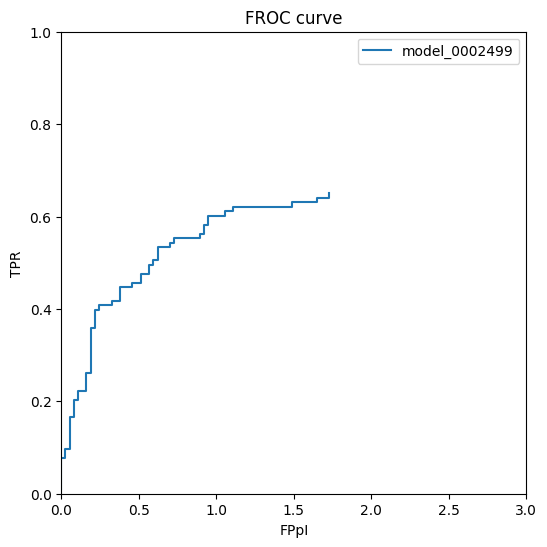

In [33]:
### editable
FROC_info_dir = repo_path / 'detection/evaluation/data/validation/split_1/normal_fine-tuning'
FPpI_limit = 3
###

# get all csv files
csv_files = list(FROC_info_dir.rglob('*.csv'))
csv_files.sort(key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('FPpI')
ax.set_ylabel('TPR')
ax.set_title('FROC curve')
# set TPR limits
ax.set_ylim(0,1)
ax.set_xlim(0,FPpI_limit)

for csv_path in csv_files[0:1]:
    model_name = csv_path.stem
    froc_info = pd.read_csv(csv_path)
    ax.plot(froc_info['FPpI'], froc_info['TPR'], marker='', label=f'{model_name}', linestyle='-', linewidth=1.5)
ax.legend()

The area can be computed using the trapezoidal rule. We only need to define the max FPpI limit.

## AUFROC and Sensitivity trials

In [48]:
def computing_sensitivity_at_FPpI(froc_info):
    # compute sensitivity at 1/4, 1/2, 1, 2, 4 FPpI
    sen_at = [1/2, 1, 2, 3, 4]
    sensitivity_df = None
    for FPpI in sen_at:
        c_sen = np.interp(x=FPpI, xp=froc_info['FPpI'], fp=froc_info['TPR'])
        c_sen_df = pd.DataFrame({'FPpI': [FPpI], 'sensitivity': [c_sen]})
        sensitivity_df = pd.concat([sensitivity_df, c_sen_df], ignore_index=True)

    average_sen = sensitivity_df['sensitivity'].mean()
    return sensitivity_df, average_sen
    

In [50]:
### Editable
FROC_info_dir = repo_path / 'detection/evaluation/data/validation/split_1/normal_fine-tuning'
###

# saving_AUFROCs and sensitivity
AUFROC_dir = FROC_info_dir.parent / 'AUFROCs'
Sen_mean_dir = FROC_info_dir.parent / 'sensitivity'
AUFROC_dir.mkdir(parents=True, exist_ok=True)
Sen_mean_dir.mkdir(parents=True, exist_ok=True)
# get all csv files
csv_files = list(FROC_info_dir.rglob('*.csv'))

AUFROC_df = None
Sen_mean_df = None
# example of model curve
for csv_path in csv_files:

    model_name = csv_path.stem
    froc_info = pd.read_csv(csv_path)

    # compute metrics
    AUFROC_value = AUFROC_computing(froc_info)
    AUFROC_df = pd.concat([AUFROC_df, pd.DataFrame({'model_name': [model_name], 'AUFROC': [AUFROC_value]})], ignore_index=True)
    # sensitivity
    _, sen_mean = computing_sensitivity_at_FPpI(froc_info)
    Sen_mean_df = pd.concat([Sen_mean_df, pd.DataFrame({'model_name': [model_name], 'sensitivity_mean': [sen_mean]})], ignore_index=True)
# save
AUFROC_df.to_csv(AUFROC_dir / f'{FROC_info_dir.name}.csv', index=False)
Sen_mean_df.to_csv(Sen_mean_dir / f'{FROC_info_dir.name}.csv', index=False)

## Selecting the best

Using the mean sensitivity as the main metric, we select the best model.

In [82]:
def get_best_models(split_name, metric_name):
    """given a split and a metric, get the best models for each model type

    Args:
        split_name (str): split name
        metric_name (str): metric name: sensitivity, AUFROC
    """
    # save the best models
    best_model_saving = repo_path / f'detection/evaluation/data/validation' / f'{split_name}' / 'best_models'
    best_model_saving.mkdir(parents=True, exist_ok=True)
    # select the best model among all possible type
    metric_dir = repo_path / f'detection/evaluation/data/validation/{split_name}/{metric_name}'
    csv_files = list(metric_dir.rglob('*.csv'))

    best_models = None
    for csv_path in csv_files:
        model_type = csv_path.stem
        sensitivity_df = pd.read_csv(csv_path)
        sensitivity_df = sensitivity_df.sort_values(by='metric', ascending=False)
        top_model = sensitivity_df.iloc[0]
        # save as dataframe
        top_model_df = pd.DataFrame(
            {'model_type': [model_type],
            'model_name': [top_model['model_name']],
            'metric': [top_model['metric']]})
        best_models = pd.concat([best_models, top_model_df], ignore_index=True)

    # save best models
    best_models.to_csv(best_model_saving / f'best_models_{metric_name}.csv', index=False)

    return best_models

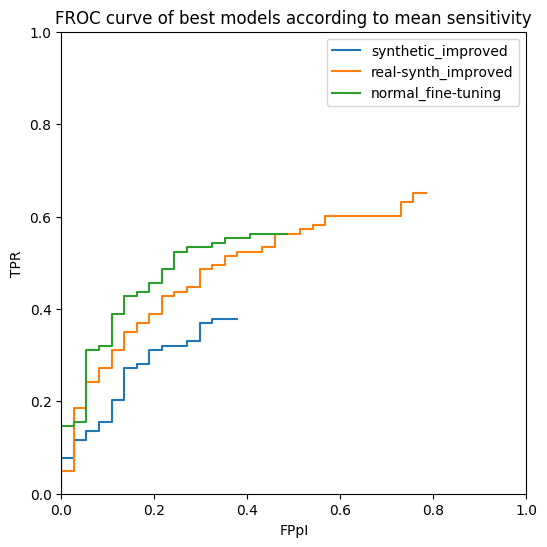

In [83]:
split_name = 'split_1'
metric_name = 'AUFROC'

best_models = get_best_models(split_name, metric_name)

# show the best models curves
### editable
FPpI_limit = 1
###


split_dir = repo_path / f'detection/evaluation/data/validation/{split_name}'

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('FPpI')
ax.set_ylabel('TPR')
ax.set_title('FROC curve of best models according to mean sensitivity')
# set TPR limits
ax.set_ylim(0,1)
ax.set_xlim(0,FPpI_limit)

for i, row in best_models.iterrows():
    csv_path = split_dir / row['model_type'] / f'{row["model_name"]}.csv'
    model_type = row['model_type']
    froc_info = pd.read_csv(csv_path)
    ax.plot(froc_info['FPpI'], froc_info['TPR'], marker='', label=f'{model_type}', linestyle='-', linewidth=1.5)
ax.legend()